# Multi-trait LMMs

#### Set up environment

In [126]:
%matplotlib inline

import sys
import scipy as sp
import scipy.stats as st
import pylab as pl
import pandas as pd
sp.random.seed(0)

import limix.util as lmx_util
import limix.plot as lmx_plt

#### Download data

We here load the yeast dataset. The data used in this study have been pre-converted into an hdf5 file. To preprocess your own data, please use limix command line brinary.

In [127]:
sys.path.append('./..')
import data as tutorial_data
file_name = tutorial_data.get_file('BYxRM')

#### Set up data object

The data object allows to query specific genotype or phenotype data

In [128]:
from limix.io import genotype_reader as gr
from limix.io import phenotype_reader as phr
from limix.io import data

In [129]:
geno_reader  = gr.genotype_reader_tables(file_name)
pheno_reader = phr.pheno_reader_tables(file_name)
dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)

#### Visualizing the trait measurements

In [130]:
phenotypes,sample_idx = dataset.getPhenotypes(intersection=True)
phenotype_names = dataset.phenotype_ID

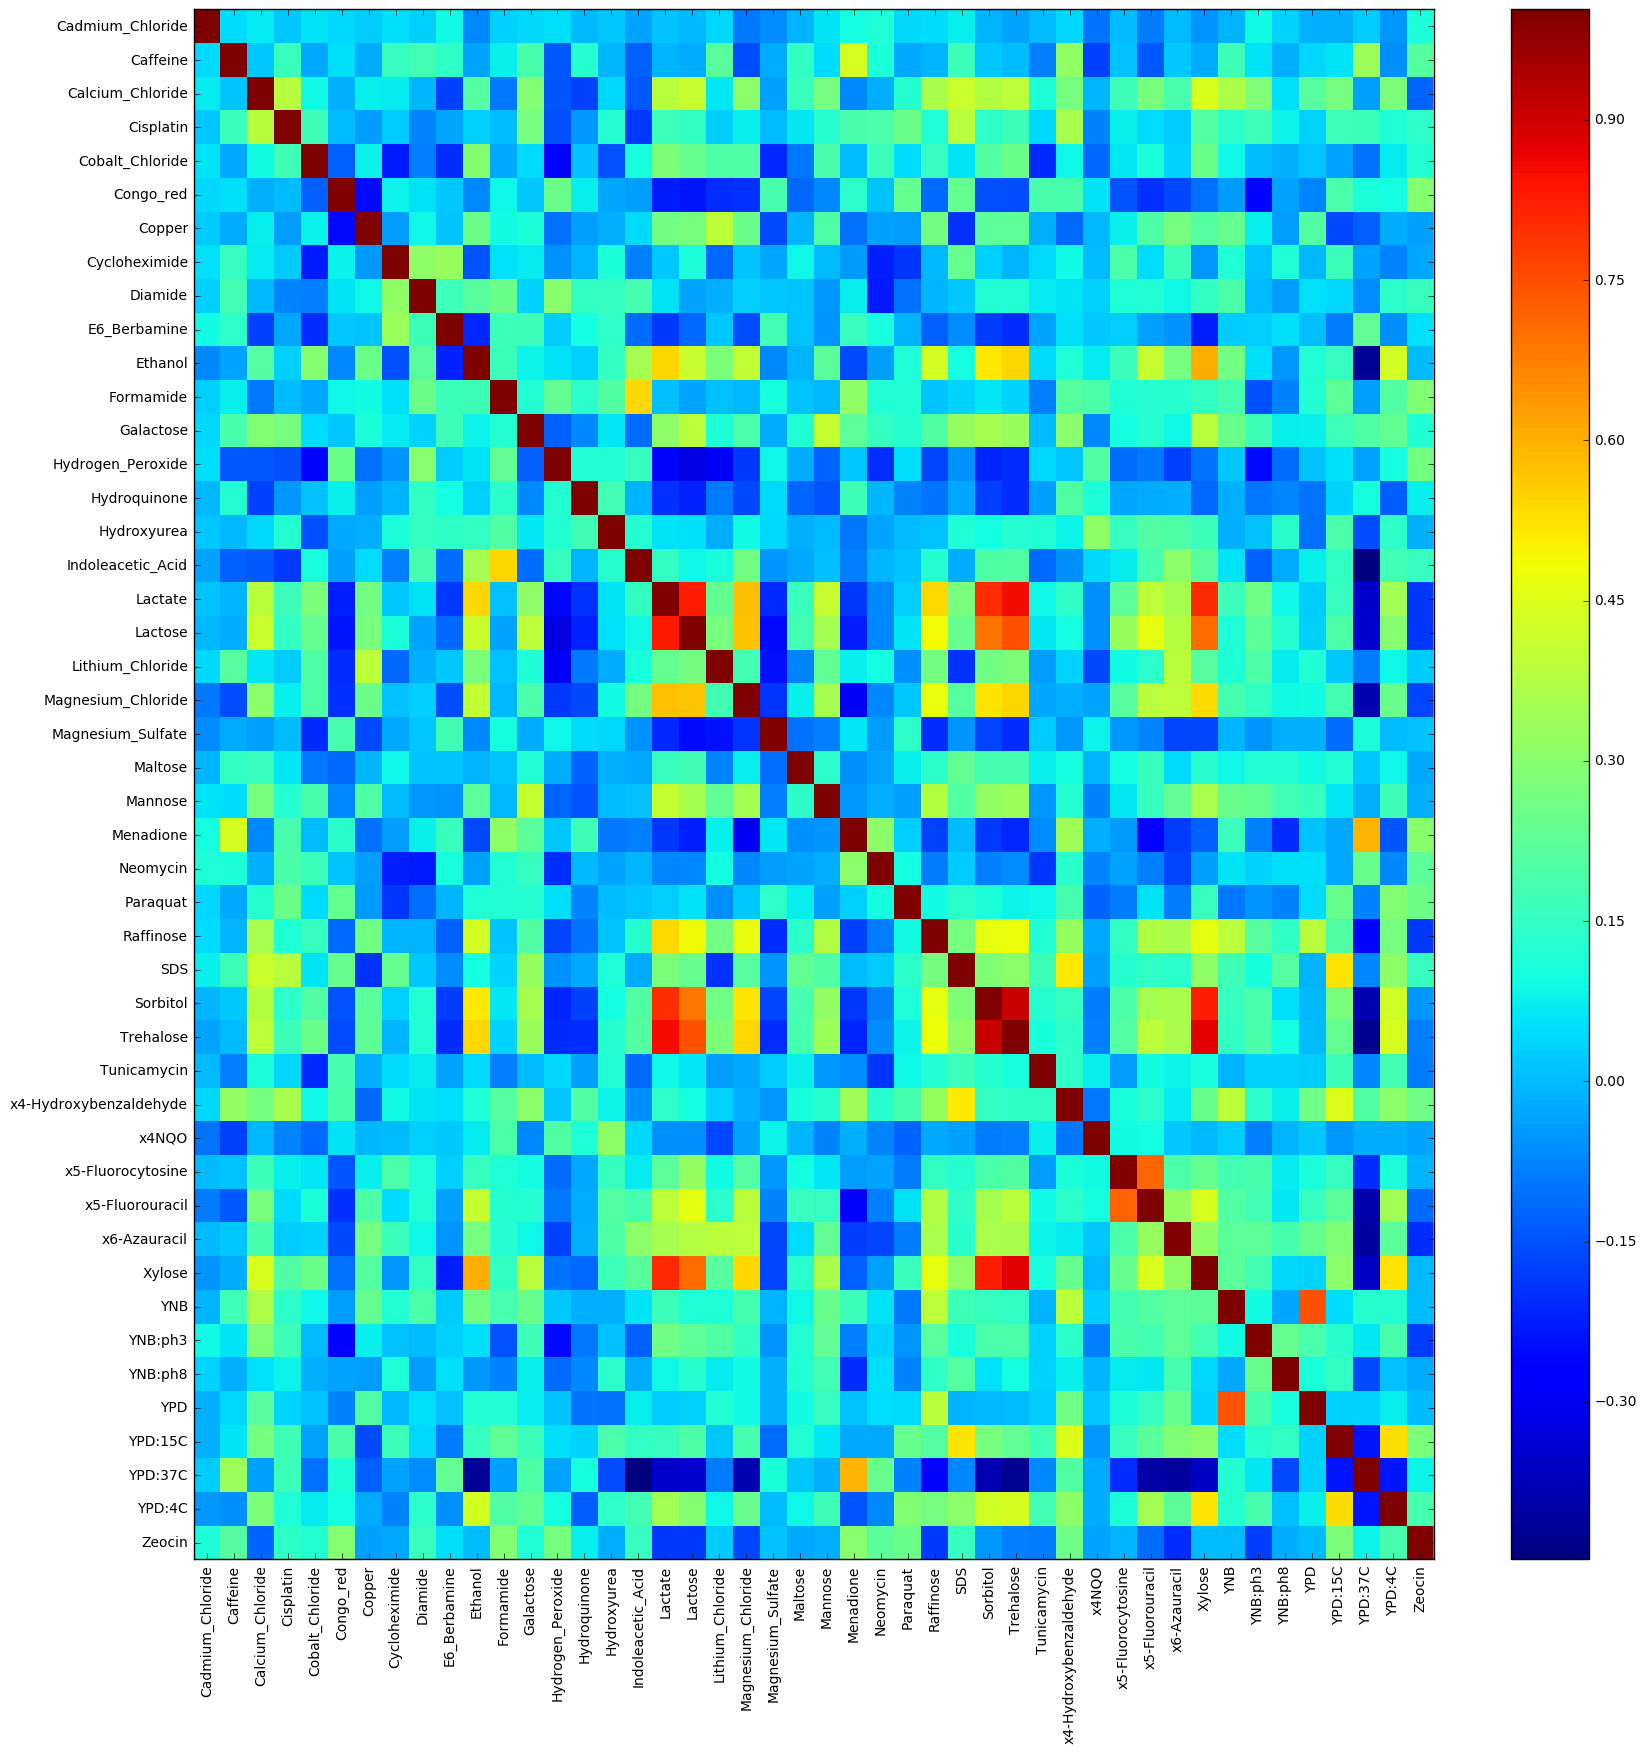

In [131]:
pl.figure(figsize=[20,20])
Ce= sp.cov(phenotypes.values.T)
pl.imshow(Ce,aspect='auto',interpolation='none')
pl.xticks(sp.arange(len(phenotype_names)),phenotype_names,rotation=90)
pl.yticks(sp.arange(len(phenotype_names)),phenotype_names,rotation=0)
pl.colorbar()

#### Select a subset of phenotypes

In [132]:
phenotype_names = ['YPD:37C','YPD:15C','YPD:4C']
phenotype_query = "(phenotype_ID in %s)" %  str(phenotype_names)
data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                              intersection=True)

In [133]:
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query) 
phenotype_std = lmx_util.preprocess.rankStandardizeNormal(phenotypes.values)

We start examining their correlation:

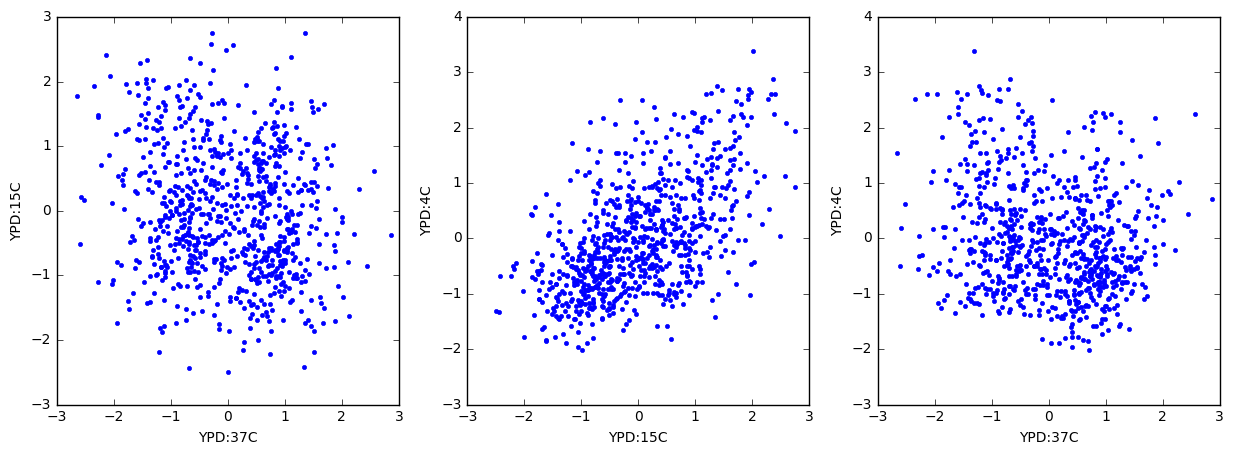

In [134]:
#pairwise corrrelations of the first 3 traits
pl.figure(figsize=[15,5])
pl.subplot(1,3,1)
pl.plot(phenotypes[phenotype_names[0]].values,phenotypes[phenotype_names[1]].values,'.')
pl.xlabel(phenotype_names[0])
pl.ylabel(phenotype_names[1])

pl.subplot(1,3,2)
pl.plot(phenotypes[phenotype_names[1]].values,phenotypes[phenotype_names[2]].values,'.')
pl.xlabel(phenotype_names[1])
pl.ylabel(phenotype_names[2])

pl.subplot(1,3,3)
pl.plot(phenotypes[phenotype_names[0]].values,phenotypes[phenotype_names[2]].values,'.')
pl.xlabel(phenotype_names[0])
pl.ylabel(phenotype_names[2])

# Variance Decomposition

We here show how to estimate the genetic and residuals covariances using the limix class limix.varDecomp.VarianceDecomposition (see [here][1]).

[1]:http://limix.readthedocs.io/varDecomp.html

In [135]:
from limix.varDecomp import VarianceDecomposition

In [136]:
# genetic relatedness matrix
sample_relatedness = data_subsample.getCovariance(normalize=True,center=True)

In [137]:
# variance component model
vc = VarianceDecomposition(phenotypes.values)
vc.addFixedEffect()
vc.addRandomEffect(K=sample_relatedness)
vc.addRandomEffect(is_noise=True)
vc.optimize()
# retrieve geno and noise covariance matrix
Cg = vc.getTraitCovar(0)
Cn = vc.getTraitCovar(1)

#### Emprirical Covariance

In [138]:
Ce = sp.corrcoef(phenotypes.T)

#### Plot empirical, genetic and residuals covariances

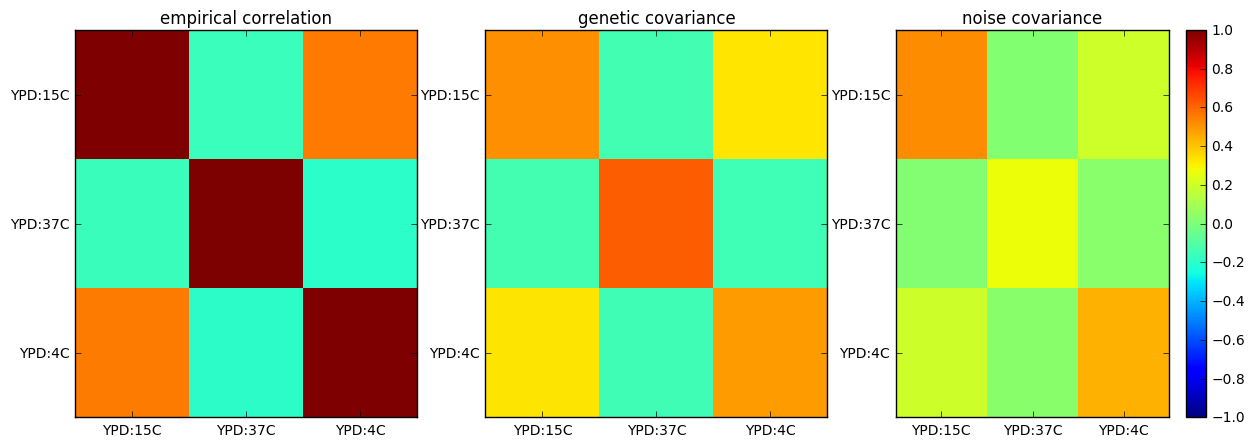

In [139]:
pl.figure(figsize=[15,5])
pl.subplot(1,3,1)
pl.imshow(Ce,aspect='auto',interpolation='none',vmin=-1,vmax=1)
pl.xticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.yticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.title('empirical correlation')

pl.subplot(1,3,2)
pl.imshow(Cg,aspect='auto',interpolation='none',vmin=-1,vmax=1)
pl.xticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.yticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.title('genetic covariance')


pl.subplot(1,3,3)
pl.imshow(Cn,aspect='auto',interpolation='none',vmin=-1,vmax=1)
pl.xticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.yticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.title('noise covariance')
pl.colorbar()

# Univariate association testing

Univariate association testig with linear mixed models can be performed using the function ``limix.qtl.qtl_test_lmm`` (see [here][1]).

[1]:http://limix.readthedocs.io/qtl.html#limix.qtl.qtl_test_lmm

In [140]:
from limix.qtl import qtl_test_lmm

In [141]:
# load snp data
snps = data_subsample.getGenotypes(center=False,unit=False)
position = data_subsample.getPos()

In [142]:
#convert P-values to a DataFrame for nice output writing:
lmm = qtl_test_lmm(snps=snps,
                   pheno=phenotypes.values,
                   K=sample_relatedness)
pv_lmm = lmm.getPv()

Convert P-values to a DataFrame for nice output writing:

In [143]:
pvalues_lmm = pd.DataFrame(data=pv_lmm.T,
                           index=data_subsample.geno_ID,
                           columns=phenotype_names)

Genome-wide manhatton plots obtained from a univariate LMM:

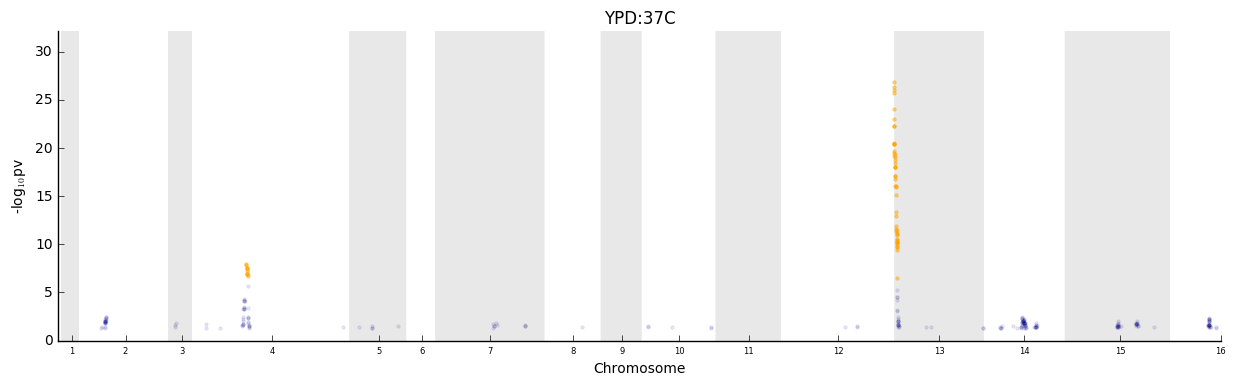

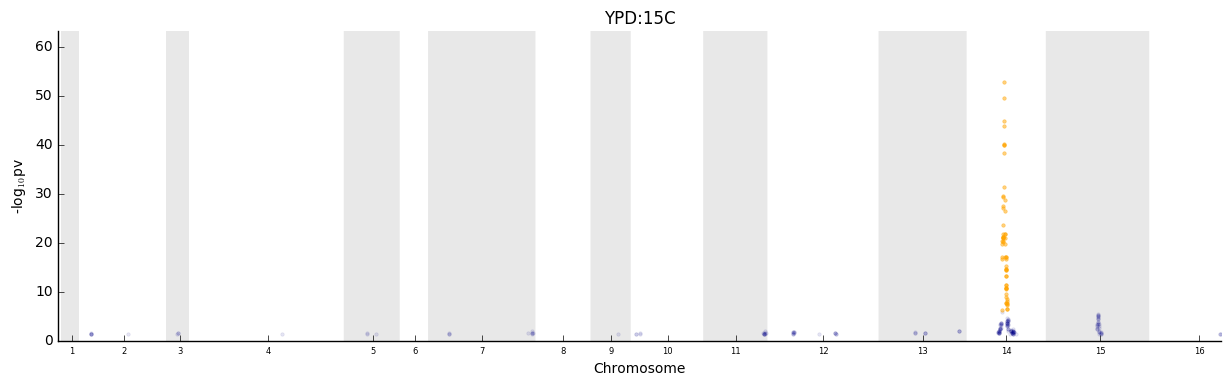

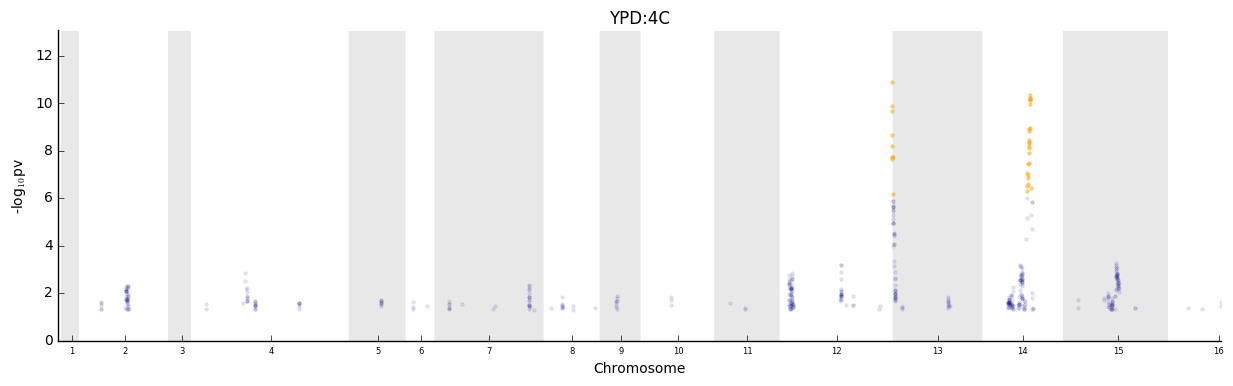

In [144]:
for p_ID in phenotype_names:
    pl.figure(figsize=[15,4])
    lmx_plt.plot_manhattan(pvalues_lmm[p_ID].values,position,thr_plotting=0.05)
    pl.title(p_ID)

# Multi-trait Association testing

Multi-trait association testing with linear mixed models can be performed using the function ``limix.qtl.qtl_test_lmm_kroncker`` (see [here][1]).

[1]:http://limix.readthedocs.io/qtl.html#limix.qtl.qtl_test_lmm_kroncker

In the following we will showcase how to perform the following multi-trait tests:
- any effect test (test for an effect on any of the phenotypes)
- common effect test (test for an effect that is common to all phenotypes)
- specific effect test (test for an effect that is specific to some)

### Any effect test

In [145]:
N, P = phenotypes.values.shape

In [146]:
covs = sp.ones((N, 1))      #covariates
Acovs = sp.eye(P)           #the design matrix for the covariates   
Asnps = sp.eye(P)           #the design matrix for the SNPs
K1r = sample_relatedness    #the first sample-sample covariance matrix (non-noise)

In [147]:
from limix.qtl import qtl_test_lmm_kronecker

In [148]:
lmm, pvalues = qtl_test_lmm_kronecker(snps=snps,
                                      phenos=phenotypes.values,
                                      covs=covs,
                                      Acovs=Acovs,
                                      Asnps=Asnps,
                                      K1r=K1r)

convert P-values to a DataFrame for nice output writing:

In [149]:
pvalues = pd.DataFrame(data=pvalues.T,index=data_subsample.geno_ID,columns=['multi_trait'])

#### Manhattan plot

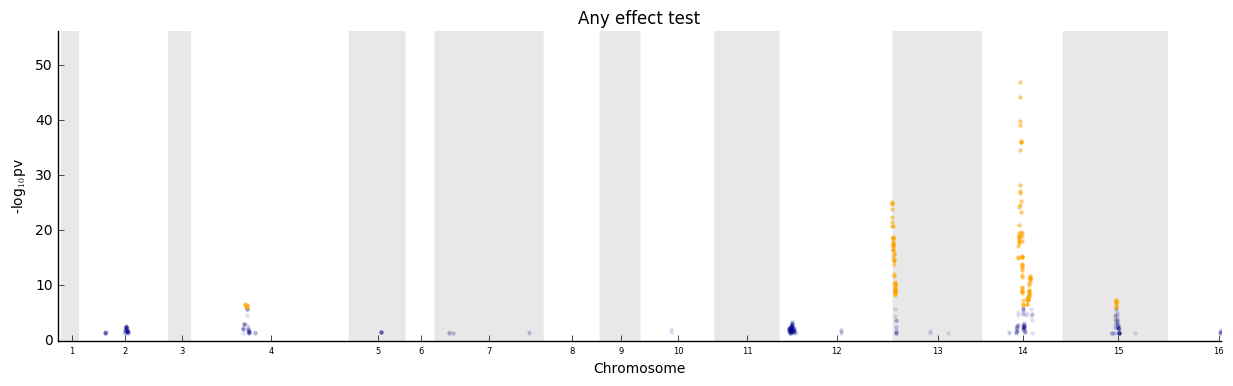

In [150]:
pl.figure(figsize=[15,4])
pl.title('Any effect test')
lmx_plt.plot_manhattan(pvalues['multi_trait'].values,
                       position,
                       thr_plotting=0.05)

### Common effect test

A common effect test is a 1 degree of freedom test and can be done by setting
\begin{equation}
\mathbf{A}_1^\text{(snp)} = \mathbf{1}_{1,P},\;\;\;
\mathbf{A}_0^\text{(snp)} = \mathbf{0}
\end{equation}

In [151]:
covs = sp.ones((N, 1))      #covariates
Acovs = sp.eye(P)           #the design matrix for the covariates   
Asnps = sp.ones((1,P))      #the design matrix for the SNPs
K1r = sample_relatedness    #the first sample-sample covariance matrix (non-noise)

In [152]:
lmm, pvalues_common = qtl_test_lmm_kronecker(snps=snps[sample_idx],
                                             phenos=phenotypes.values,
                                             covs=covs,
                                             Acovs=Acovs,
                                             Asnps=Asnps,
                                             K1r=K1r)

convert P-values to a DataFrame for nice output writing:

In [153]:
pvalues_common = pd.DataFrame(data=pvalues_common.T,index=data_subsample.geno_ID,columns=['common'])

#### Manhattan plot

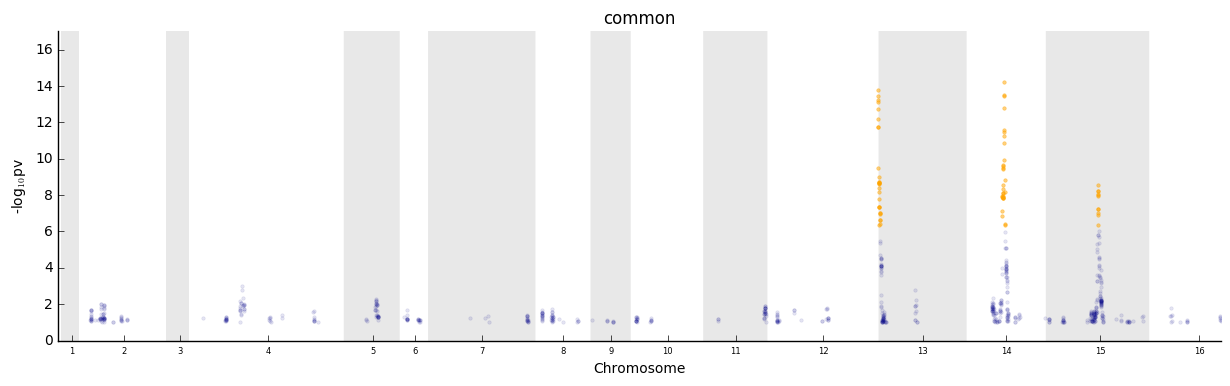

In [154]:
pl.figure(figsize=[15,4])
pl.title('common')
lmx_plt.plot_manhattan(pvalues_common['common'].values,
                       position,
                       thr_plotting=0.1)

#### Testing for specific effect test

For a specifc effect test for trait $p$
the alternative model is set to have both a common and a specific effect
for transcript $p$ from the SNP while the null model has only a common effect.

It is a 1 degree of freedom test and,
in the particular case of $P=3$ traits and for $p=0$, it can be done by setting
\begin{equation}
\mathbf{A}_1^\text{(snp)} =
\begin{pmatrix}
  1 & 0 & 0 \\
  1 & 1 & 1
 \end{pmatrix}
\;\;\;,
\mathbf{A}_0^\text{(snp)} = \mathbf{1}_{1,3}
\end{equation}

Specific effect tests can be performed using the function ``limix.qtl.qtl_test_interaction_lmm_kronecker`` (see [here][1]).

[1]:http://limix.readthedocs.io/qtl.html#limix.qtl.qtl_test_interaction_lmm_kronecker

In [155]:
Asnps0 = sp.ones((1,P))     #the null model design matrix for the SNPs
Asnps1 = sp.zeros((2,P))    #the alternative model design matrix for the SNPs
Asnps1[0,:] = 1.0       
Asnps1[1,0] = 1.0  
print "Design(0): \n"+str(Asnps0)
print "Design(Alt): \n"+str(Asnps1)

Design(0): 
[[ 1.  1.  1.]]
Design(Alt): 
[[ 1.  1.  1.]
 [ 1.  0.  0.]]


In [156]:
from limix.qtl import qtl_test_interaction_lmm_kronecker

pvalues_inter = qtl_test_interaction_lmm_kronecker(snps=snps[sample_idx],
                                                   phenos=phenotypes.values,
                                                   covs=covs,
                                                   Acovs=Acovs,
                                                   Asnps0=Asnps0,
                                                   Asnps1=Asnps1,
                                                   K1r=K1r)

convert P-values to a DataFrame for nice output writing:

In [157]:
pvalues_inter = pd.DataFrame(data=sp.concatenate(pvalues_inter).T,
                             index=data_subsample.geno_ID,
                             columns=["specific","null_common","alternative_any"])

#### Manhattan plot

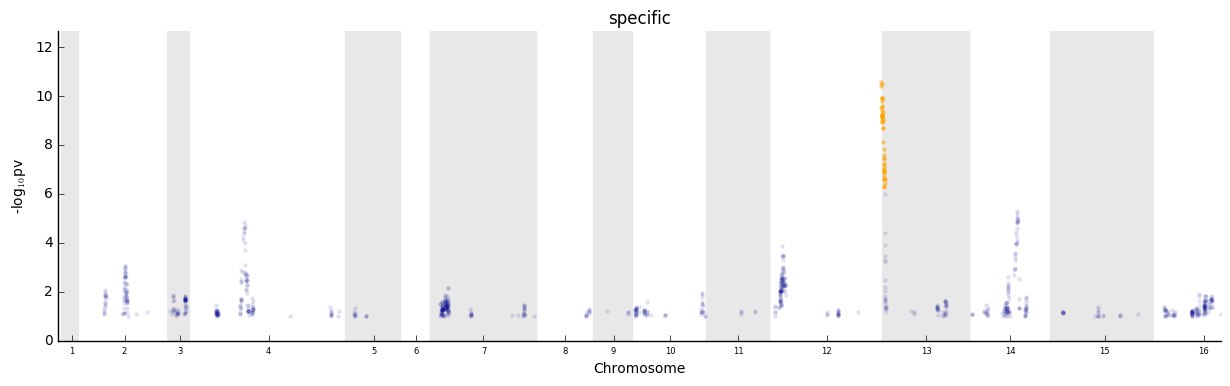

In [158]:
pl.figure(figsize=[15,4])
pl.title('specific')
lmx_plt.plot_manhattan(pvalues_inter['specific'].values,
                       position,
                       thr_plotting=0.1)